In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

import gensim
from gensim.models import KeyedVectors

from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import re



### 1) 데이터 준비와 확인

In [2]:
from pathlib import Path
directory = Path.joinpath(Path.cwd(),'data')

filename = 'ko.bin' # Filename
word2vec_file_path  = Path.joinpath(directory,filename)
word2vec = gensim.models.Word2Vec.load(str(word2vec_file_path))

# 데이터를 읽어봅시다. 
train_data_path = Path.joinpath(directory, 'ratings_train.txt')
test_data_path  = Path.joinpath(directory, 'ratings_test.txt')

train_data      = pd.read_table(train_data_path)
test_data       = pd.read_table(test_data_path)

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
vocab_size      = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200      # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
BUFFER_SIZE     = 10000
# BATCH_SIZE      = 512
BATCH_SIZE      = 1024
epochs          = 14
# steps_per_epoch = 1

# 약 146000건의 train 데이터
# validation set 사이즈
# int_partition = steps_per_epoch * epochs * BATCH_SIZE
int_partition = 12 * BATCH_SIZE

print(int_partition)

12288


### 2) 데이터로더 구성

In [4]:
from ckonlpy.tag import Twitter
# tokenizer =  Twitter()

tokenizer = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
# tokenizer = Mecab()
stopwords = ['수', '거', '기','이', '는', '다', '고', '하', '도', '의', '가', '은', '에', '을', '보', '한', '들', '지', '를', '나', '었', '만']

hangul = re.compile('[^ 가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자

def load_data(train_data, test_data):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        sentence = hangul.sub(" ", sentence)
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        sentence = hangul.sub(" ", sentence)
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
     
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(vocab_size-4)
    
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)



In [5]:
x_train[:5]

[[19, 57, 863, 25, 202, 20, 683],
 [952, 467, 477, 625, 4, 101, 1533, 37, 853, 930, 30, 348],
 [10, 180, 3],
 [8004, 133, 4030, 264, 76, 7, 42, 3301],
 [3,
  8458,
  1030,
  37,
  2677,
  44,
  4,
  2605,
  26,
  1102,
  22,
  311,
  27,
  44,
  3,
  3,
  379,
  2898,
  1653]]

In [6]:
y_train[:5]

array([0, 1, 0, 0, 1])

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수. 
#모든 문장은 <BOS>로 시작해야 함. 
def get_encoded_sentence(sentence, word_to_index):
    sentence = hangul.sub(" ", sentence) # 한글만 통과
    temp_X = tokenizer.morphs(sentence)  # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거    
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in temp_X]

#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

#여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [9]:
for i in range(5):
    print(x_train[i])
    print(get_decoded_sentence(x_train[i], index_to_word))
    print('라벨: ', y_train[i])

[19, 57, 863, 25, 202, 20, 683]
더 빙 진짜 짜증 네요 목소리
라벨:  0
[952, 467, 477, 625, 4, 101, 1533, 37, 853, 930, 30, 348]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 않 구나
라벨:  1
[10, 180, 3]
재 
라벨:  0
[8004, 133, 4030, 264, 76, 7, 42, 3301]
이야기 구먼 솔직히 재미 없 평점 조정
라벨:  0
[3, 8458, 1030, 37, 2677, 44, 4, 2605, 26, 1102, 22, 311, 27, 44, 3, 3, 379, 2898, 1653]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 했 던   너무나 이뻐 보였
라벨:  1


In [10]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


문장길이 평균 :  11.87655306927956
문장길이 최대 :  71
문장길이 표준편차 :  9.975205954032385
pad_sequences maxlen :  21
전체 문장의 0.87194057510277%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"]    = 0
word_to_index["<BOS>"]    = 1
word_to_index["<UNK>"]    = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
for i in range(5):
    print(index_to_word[i])

<PAD>
<BOS>
<UNK>
<UNUSED>
영화


In [13]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

C:\Users\ami\AppData\Local\Temp\ipykernel_17564\1390784066.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
C:\Users\ami\AppData\Local\Temp\ipykernel_17564\1390784066.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    '''
    히스토리 그래프
    '''
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [15]:
def predict(model, sentences, word_to_index, index_to_word, maxlen):
    '''
    점수예측
    '''
    encoded_sentences = get_encoded_sentences(sentences, word_to_index)
#     print(encoded_sentences)
    decoded_sentences = get_decoded_sentences(encoded_sentences, index_to_word)
#     print(decoded_sentences)
    to_test = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences,
                                                           value=word_to_index["<PAD>"],
                                                           padding='post', # 혹은 'pre'
                                                           maxlen=maxlen)
    predictions = model.predict(to_test)
    print(predictions)

### 4) 모델 구성 및 validation set 구성

In [16]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 21)


In [17]:
x_val = x_train[:int_partition]   
y_val = y_train[:int_partition]

# validation set을 제외한 나머지 
partial_x_train = x_train[int_partition:]  
partial_y_train = y_train[int_partition:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(133894, 21)
(133894,)


#### 모델1. 컨볼루션 레이어로 구성

In [18]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model_Conv1D = tf.keras.Sequential()
model_Conv1D.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_Conv1D.add(tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'))
model_Conv1D.add(tf.keras.layers.MaxPooling1D(3))
model_Conv1D.add(tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same'))
model_Conv1D.add(tf.keras.layers.MaxPooling1D(3))
model_Conv1D.add(tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same'))
model_Conv1D.add(tf.keras.layers.GlobalMaxPooling1D())
model_Conv1D.add(tf.keras.layers.Dense(8, activation='relu'))
# model_Conv1D.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_Conv1D.add(tf.keras.layers.Dropout(0.5))
model_Conv1D.add(tf.keras.layers.Dense(1, activation='tanh')) #추가 
model_Conv1D.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 200)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 21, 16)            9616      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 8)              392       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 8)             0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 8)              2

In [19]:
model_Conv1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
# epochs_Conv=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history_Conv1D = model_Conv1D.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/14
131/131 [==============================] - 6s 20ms/step - loss: 1.5642 - accuracy: 0.5068 - val_loss: 0.7207 - val_accuracy: 0.5220
Epoch 2/14
131/131 [==============================] - 2s 16ms/step - loss: 0.9735 - accuracy: 0.5159 - val_loss: 0.7008 - val_accuracy: 0.5397
Epoch 3/14
131/131 [==============================] - 2s 17ms/step - loss: 0.8423 - accuracy: 0.5344 - val_loss: 0.6713 - val_accuracy: 0.5805
Epoch 4/14
131/131 [==============================] - 2s 16ms/step - loss: 0.8015 - accuracy: 0.5558 - val_loss: 0.6404 - val_accuracy: 0.6248
Epoch 5/14
131/131 [==============================] - 2s 17ms/step - loss: 0.7484 - accuracy: 0.6021 - val_loss: 0.5850 - val_accuracy: 0.6891
Epoch 6/14
131/131 [==============================] - 2s 16ms/step - loss: 0.6814 - accuracy: 0.6643 - val_loss: 0.5249 - val_accuracy: 0.7411
Epoch 7/14
131/131 [==============================] - 2s 17ms/step - loss: 0.6143 - accuracy: 0.7195 - val_loss: 0.4734 - val_accuracy: 0.7742

In [20]:
test_loss, test_acc = model_Conv1D.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


1537/1537 [==============================] - 8s 5ms/step - loss: 0.4209 - accuracy: 0.8147
Test Loss: 0.42085176706314087
Test Accuracy: 0.8146754503250122


(0.0, 1.622066205739975)

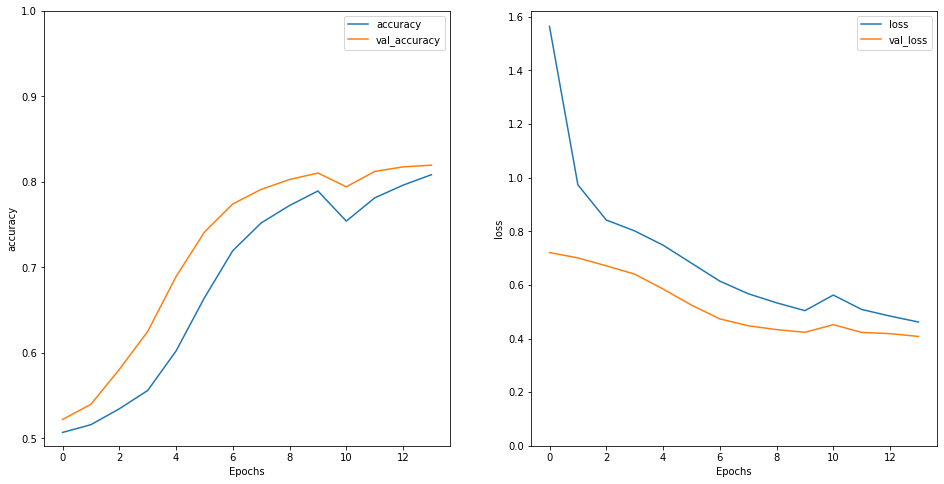

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_Conv1D, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_Conv1D, 'loss')
plt.ylim(0, None)

#### 모델2.  RNN LSTM 1레이어로 구성

In [22]:
from tensorflow.keras.initializers import Constant

model_LSTM1 = tf.keras.Sequential()
model_LSTM1.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_LSTM1.add(tf.keras.layers.Dense(64, activation='relu'))
# model_LSTM1.add(tf.keras.layers.Dense(1))
model_LSTM1.add(tf.keras.layers.Dropout(0.5))
# model_LSTM1.add(tf.keras.layers.Dense(1, activation='sigmoid')) #추가     
model_LSTM1.add(tf.keras.layers.Dense(1, activation='tanh')) #추가   
model_LSTM1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 200)           2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,144,001
Trainable params: 2,144,001
Non-trainable params: 0
____________________________________________

In [23]:
print([layer.supports_masking for layer in model_LSTM1.layers])

[False, True, True, True, True]


In [24]:
model_LSTM1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history_LSTM1 = model_LSTM1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/14
131/131 [==============================] - 8s 40ms/step - loss: 0.6747 - accuracy: 0.5390 - val_loss: 0.6314 - val_accuracy: 0.5942
Epoch 2/14
131/131 [==============================] - 5s 37ms/step - loss: 0.6078 - accuracy: 0.6560 - val_loss: 0.5725 - val_accuracy: 0.7138
Epoch 3/14
131/131 [==============================] - 5s 37ms/step - loss: 0.5641 - accuracy: 0.7197 - val_loss: 0.5451 - val_accuracy: 0.7472
Epoch 4/14
131/131 [==============================] - 5s 37ms/step - loss: 0.5406 - accuracy: 0.7504 - val_loss: 0.5300 - val_accuracy: 0.7611
Epoch 5/14
131/131 [==============================] - 5s 37ms/step - loss: 0.5243 - accuracy: 0.7693 - val_loss: 0.5175 - val_accuracy: 0.7786
Epoch 6/14
131/131 [==============================] - 5s 37ms/step - loss: 0.5118 - accuracy: 0.7841 - val_loss: 0.5118 - val_accuracy: 0.7798
Epoch 7/14
131/131 [==============================] - 5s 38ms/step - loss: 0.5038 - accuracy: 0.7936 - val_loss: 0.5019 - val_accuracy: 0.7977

In [26]:
test_loss, test_acc = model_LSTM1.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1537/1537 [==============================] - 11s 6ms/step - loss: 0.4859 - accuracy: 0.8142
Test Loss: 0.48588335514068604
Test Accuracy: 0.8142075538635254


(0.0, 0.6852126821875573)

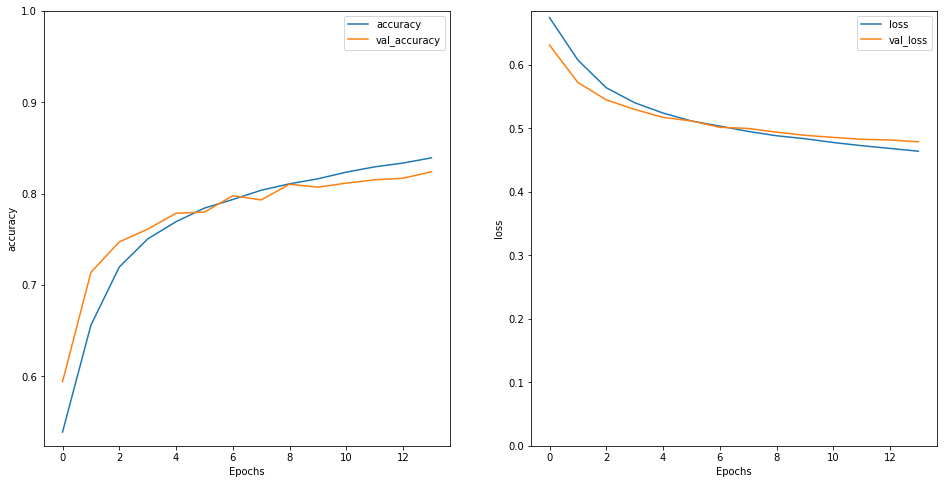

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_LSTM1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_LSTM1, 'loss')
plt.ylim(0, None)

#### 모델3. RNN LSTM 2레이어로 구성

In [28]:
model_LSTM2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.Dense(1, activation='sigmoid') #추가 
    tf.keras.layers.Dense(1, activation='tanh') #추가     
])

model_LSTM2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 21, 200)           2000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 21, 128)          135680    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [29]:
model_LSTM2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history_LSTM2 = model_LSTM2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/14
131/131 [==============================] - 13s 63ms/step - loss: 0.6534 - accuracy: 0.5497 - val_loss: 0.5870 - val_accuracy: 0.6919
Epoch 2/14
131/131 [==============================] - 7s 50ms/step - loss: 0.5685 - accuracy: 0.7150 - val_loss: 0.5426 - val_accuracy: 0.7491
Epoch 3/14
131/131 [==============================] - 7s 51ms/step - loss: 0.5387 - accuracy: 0.7558 - val_loss: 0.5264 - val_accuracy: 0.7744
Epoch 4/14
131/131 [==============================] - 7s 51ms/step - loss: 0.5222 - accuracy: 0.7753 - val_loss: 0.5157 - val_accuracy: 0.7832
Epoch 5/14
131/131 [==============================] - 7s 50ms/step - loss: 0.5108 - accuracy: 0.7881 - val_loss: 0.5080 - val_accuracy: 0.7928
Epoch 6/14
131/131 [==============================] - 7s 51ms/step - loss: 0.5016 - accuracy: 0.7992 - val_loss: 0.5031 - val_accuracy: 0.7925
Epoch 7/14
131/131 [==============================] - 7s 51ms/step - loss: 0.4932 - accuracy: 0.8083 - val_loss: 0.4961 - val_accuracy: 0.802

In [31]:
test_loss, test_acc = model_LSTM2.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1537/1537 [==============================] - 16s 9ms/step - loss: 0.4847 - accuracy: 0.8224
Test Loss: 0.48468706011772156
Test Accuracy: 0.8223650455474854


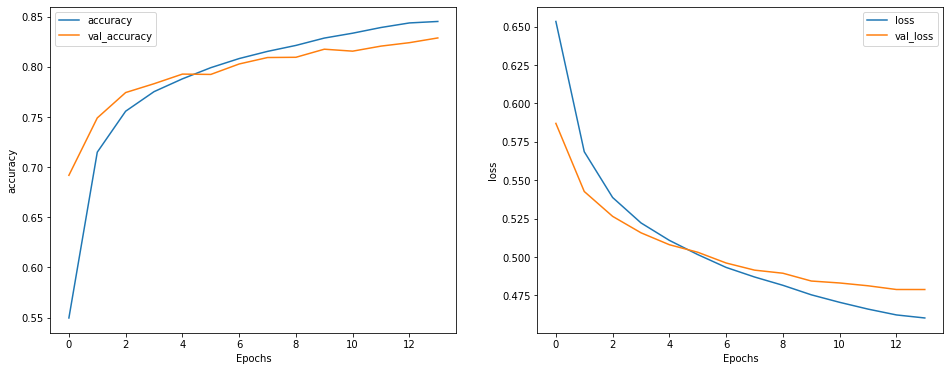

In [32]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_LSTM2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_LSTM2, 'loss')

### 모델별 영화평 호감도 예측 점수

#### Conv1D

In [33]:
sentences = (['ㅋㅋㅋ 난생처음 로그인하고 평점남기네요.. 개빡쳐서.. 알바들 속지마세요 이런 ㄱ ㅐ같은 시간낭비가. 아놔진짜평점 마이너스 별오만개',
             '최고최고! 바다까지! 4차원 고양이 로봇 도라에몽과 함께하는 진구와 친구들의 미지 탐험 이야기!우주꺼지 갔음 좋겠당~'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.12648603]
 [0.8506328 ]]


#### LSTM1

In [34]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[-0.99890417]
 [ 0.5164766 ]]


#### LSTM2

In [35]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[-0.99967074]
 [ 0.9995213 ]]


### 다른 영화평 예측점수

#### Conv1D

In [36]:
sentences = (['다시 보고 싶은 영화. 스토리는 독특하고 연기는 자연스럽게 묻어난다. ',
             '정말 가슴아픈영화....질리지도 않는영화....몇번을봐도...음악도 너무 좋아요...OST도 구해 들었다는...'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.9615956]
 [0.9986076]]


#### LSTM1

In [37]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[0.9996607]
 [1.       ]]


#### LSTM2

In [38]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[0.9999663 ]
 [0.99999505]]


#### Conv1D

In [39]:
sentences = (['끝까지 몰입해서 볼 수 있게 chapter로 나누어서 군더더기를 생략.좋은 상대와의 결혼도 권태는 피할 수 없고 나이들면 죽음보다 더 비참한 망각-치매-가 오게 되니 100년을 살게 되면 이를 어찌 극복할 수 있을까. ',
             '좋은 배우들을 이런 영상물로 연출한것은… 너무한거 아니오'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.65801525]
 [0.19614173]]


#### LSTM1

In [40]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[ 0.9903069]
 [-0.9997293]]


#### LSTM2

In [41]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[ 0.9700645]
 [-0.9996795]]


#### Conv1D

In [42]:
sentences = (['정치 선동 영화입니다. 대선을 얼마 안남기고 전형적인 민주당식 감정 몰이 영화네요.',
             '한효주 주연하지 말아요 제발.굳이 애써 평점을 남기게 만드는 영화.모든 면에서 다채롭게 유치합니다.'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.5327185 ]
 [0.12648603]]


#### LSTM1

In [43]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[-0.8451643 ]
 [ 0.60452926]]


#### LSTM2

In [44]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[-0.97808015]
 [-0.97327685]]


### 한국어 Word2Vec 임베딩 활용하여 성능 개선
#### 사용된 세개의 모델 전부 Word2Vec 사용

#### 참고 : RNN을 사용한 텍스트 분류
https://www.tensorflow.org/text/tutorials/text_similarity?hl=ko

###  후 기 :  


#### 한국어 형태소 분류하는 프로그램의 성능이 기대에 미치지 못했고 문장의 대부분 단어들이 무시되는 결과가 되었다. 

#### 영어 같은 문장구조라면 비교적 쉬운 작업이 될 거라고 생각되지만 한국어는 컴퓨터 환경에서 '정말 너무 구리다'

#### 영어를 사용하는 영화평 감성분류 작업도 정확도가 85% 정도 나오던데 한국어 작업결과가 83% 이렇게 비슷하게 나와도 결과를 직접 확인해보면 기대에 미치지 못한다.
    
#### 차라리 문장을 통체로 딥러닝 시도하는 것이 나을 것 같다.    
    


# 2-5. 프로젝트: SentencePiece 사용하기

#### 라이브러리 버전을 확인

In [45]:
import tensorflow as tf
import numpy as np
# import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)

2.8.0
1.22.2
0.6.0


#### Step 1. SentencePiece 설치하기

#!pip install sentencepiece

### data 정제하기

In [46]:
import os
# path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

from pathlib import Path
path_to_file = Path.joinpath(Path.cwd(),'data','ratings.txt')

# with open(path_to_file, "r", encoding='UTF-8') as f:
# # with open(path_to_file, "r") as f:
#     raw = f.read().splitlines()

# print("Data Size:", len(raw))

# print("Example:")
# for sen in raw[0:100][::20]: print(">>", sen)
    
raw      = pd.read_table(path_to_file)
raw.head()    
    

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [47]:
type(raw)

pandas.core.frame.DataFrame

In [48]:
hangul = re.compile('[^ 가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자

def load_data(data):
    '''
    filtered_corpus :  사전을 만들 문장 리스트 
    '''
    data.drop_duplicates(subset=['document'], inplace=True)
    data = data.dropna(how = 'any') 
    
    filtered_corpus = []
    for i in data.index:
        val = hangul.sub(" ", data.loc[i, 'document'])
        data.loc[i, 'document'] = val
        filtered_corpus.append(val)
        
    return filtered_corpus, data

filtered_corpus, filtered_data= load_data(raw)
filtered_corpus[:5]

['어릴때보고 지금다시봐도 재밌어요 ',
 '디자인을 배우는 학생으로  외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데  사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다 ',
 '폴리스스토리 시리즈는  부터 뉴까지 버릴께 하나도 없음  최고 ',
 '와  연기가 진짜 개쩔구나  지루할거라고 생각했는데 몰입해서 봤다  그래 이런게 진짜 영화지',
 '안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화 ']

In [49]:
import sentencepiece as spm
import os
# temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
# temp_file = Path.joinpath(Path.cwd(),'data','korean-english-park.train.ko.temp')

temp_file = './data/ratings.temp'

vocab_size = 8000

with open(temp_file, 'w', encoding='UTF-8') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

# !ls -l korean_spm*

### SentencePiece 모델 활용

In [50]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1181, 7, 373, 11, 1237, 7, 140, 14, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


### Step 3. Tokenizer 함수 작성

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.
2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.
3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [51]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r',encoding='UTF-8') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

    return tensor, word_index, index_word

In [52]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 484 2378   10 1024 2602    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [1139 2146    3    0  468    7    3   12 7936  751    0    0    0    0
     0    0    0    0    0    0    0]]


## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

### tokenizer를 SentencePiece로 바꾸어 다시 풀어본다

data가 있는 곳  
https://github.com/e9t/nsmc/

네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기  
학습된 모델로 sp_tokenize() 메소드 구현하기  
구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기  
KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기  
(보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [53]:
path_to_train = Path.joinpath(Path.cwd(),'data','ratings_train.txt')
path_to_test  = Path.joinpath(Path.cwd(),'data','ratings_test.txt')

train      = pd.read_table(path_to_train)
test       = pd.read_table(path_to_test)

filtered_train_corpus, train_data = load_data(train)
x_train, _, _                     = sp_tokenize(s, filtered_train_corpus)
y_train                           = np.array(list(train_data['label'])) 

filtered_test_corpus, test_data   = load_data(test)
x_test, word_index, index_word    = sp_tokenize(s, filtered_test_corpus)
y_test = np.array(list(test_data['label']))

In [54]:
train.head()  

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [55]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [56]:
type(index_word)

dict

In [57]:
for i in range(5):
    print('{}:{}'.format(i,index_word[i]))

0:<unk>
1:<s>
2:</s>
3:▁
4:이


In [58]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수. 
#모든 문장은 <BOS>로 시작해야 함. 
def get_encoded_sentence2(sentence):
    sentence = hangul.sub(" ", sentence) # 한글만 통과
    return s.EncodeAsIds(sentence)

#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences2(sentences):
    return [get_encoded_sentence2(sentence) for sentence in sentences]

#숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence2(encoded_sentence):
    return s.DecodeIds(encoded_sentence)

#여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences2(encoded_sentences):
    return [get_decoded_sentence2(encoded_sentence) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [59]:
list_x = []
for i in range(1):
#     print(x_train[i])  # x_train[i]는 텐서
    for j in x_train[i]:
        list_x.append(int(j)) #리스트로 변환
    print(list_x)
    print(get_decoded_sentence2(list_x))
    print('라벨: ', y_train[i])

[51, 788, 23, 1822, 53, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
아 더빙 진짜 짜증나네요 목소리 ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
라벨:  0


In [60]:
type(x_train[0][1])

numpy.int32

In [61]:
type(x_train[0])

numpy.ndarray

In [62]:
def predict2(model, sentences):
    '''
    점수예측
    '''
    clean_sentences = []
    for sentence in sentences:
        clean_sentences.append(hangul.sub(" ", sentence))

#     encoded_sentences = s.EncodeAsIds(sentences)
#     decoded_sentences = s.DecodeIds(encoded_sentences)

    to_test, _, _ = sp_tokenize(s, clean_sentences)    
    predictions = model.predict(to_test)
    print(predictions)


### 4) 모델 구성 및 validation set 구성

In [63]:
# x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
#                                                         value=word_index["<PAD>"],
#                                                         padding='post', # 혹은 'pre'
#                                                         maxlen=maxlen)

# x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
#                                                        value=word_index["<PAD>"],
#                                                        padding='post', # 혹은 'pre'
#                                                        maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 21)
(49157, 21)


In [64]:
x_val = x_train[:int_partition]   
y_val = y_train[:int_partition]

# validation set을 제외한 나머지 
partial_x_train = x_train[int_partition:]  
partial_y_train = y_train[int_partition:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(133894, 21)
(133894,)


In [65]:
from tensorflow.keras.initializers import Constant

model_LSTM_SP = tf.keras.Sequential()
model_LSTM_SP.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM_SP.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_LSTM_SP.add(tf.keras.layers.Dense(64, activation='relu'))
# model_LSTM1.add(tf.keras.layers.Dense(1))
model_LSTM_SP.add(tf.keras.layers.Dropout(0.5))
# model_LSTM_SP.add(tf.keras.layers.Dense(1))
model_LSTM_SP.add(tf.keras.layers.Dense(1, activation='tanh'))

model_LSTM_SP.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 21, 200)           1600000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,744,001
Trainable params: 1,744,001
Non-trainable params: 0
____________________________________________

In [66]:
print([layer.supports_masking for layer in model_LSTM_SP.layers])

[False, True, True, True, True]


In [67]:
model_LSTM_SP.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [68]:
history_LSTM_SP = model_LSTM_SP.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/14
131/131 [==============================] - 7s 37ms/step - loss: 0.6808 - accuracy: 0.5017 - val_loss: 0.6278 - val_accuracy: 0.5032
Epoch 2/14
131/131 [==============================] - 4s 30ms/step - loss: 0.5098 - accuracy: 0.7667 - val_loss: 0.4742 - val_accuracy: 0.8312
Epoch 3/14
131/131 [==============================] - 4s 34ms/step - loss: 0.4608 - accuracy: 0.8445 - val_loss: 0.4706 - val_accuracy: 0.8314
Epoch 4/14
131/131 [==============================] - 5s 35ms/step - loss: 0.4485 - accuracy: 0.8580 - val_loss: 0.4670 - val_accuracy: 0.8359
Epoch 5/14
131/131 [==============================] - 4s 34ms/step - loss: 0.4411 - accuracy: 0.8669 - val_loss: 0.4679 - val_accuracy: 0.8394
Epoch 6/14
131/131 [==============================] - 4s 34ms/step - loss: 0.4364 - accuracy: 0.8728 - val_loss: 0.4689 - val_accuracy: 0.8371
Epoch 7/14
131/131 [==============================] - 4s 34ms/step - loss: 0.4326 - accuracy: 0.8772 - val_loss: 0.4693 - val_accuracy: 0.8382

In [69]:
test_loss, test_acc = model_LSTM_SP.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1537/1537 [==============================] - 11s 7ms/step - loss: 0.4808 - accuracy: 0.8296
Test Loss: 0.4807758331298828
Test Accuracy: 0.829627513885498


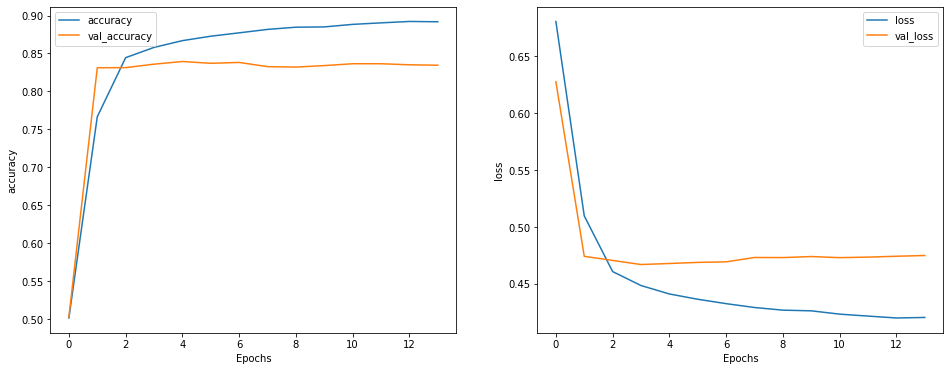

In [70]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_LSTM_SP, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_LSTM_SP, 'loss')

In [71]:
sentences = (['ㅋㅋㅋ  ㄱ ㅐ같은 시간낭비가. 아놔진짜평점 마이너스 별오만개'])
predict2(model_LSTM_SP, sentences)

[[-1.]]


In [72]:
sentences = (['정치 선동 영화입니다. 대선을 얼마 안남기고 전형적인 민주당식 감정 몰이 영화네요.',
             '한효주 주연하지 말아요 제발.굳이 애써 평점을 남기게 만드는 영화.모든 면에서 다채롭게 유치합니다.'])
predict2(model_LSTM_SP, sentences)

[[-0.9999997]
 [-0.9990001]]


# 모델별 accuracy 와 loss 값 비교

### 모델1. MeCab과 컨볼루션 레이어로 구성

(0.0, 1.622066205739975)

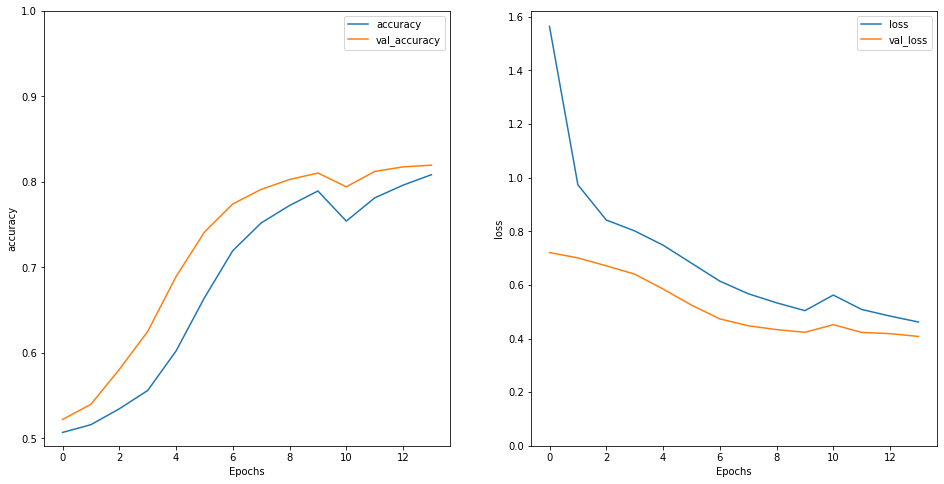

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_Conv1D, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_Conv1D, 'loss')
plt.ylim(0, None)

### 모델2. MeCab과 LSTM 으로 구성

(0.0, 0.6852126821875573)

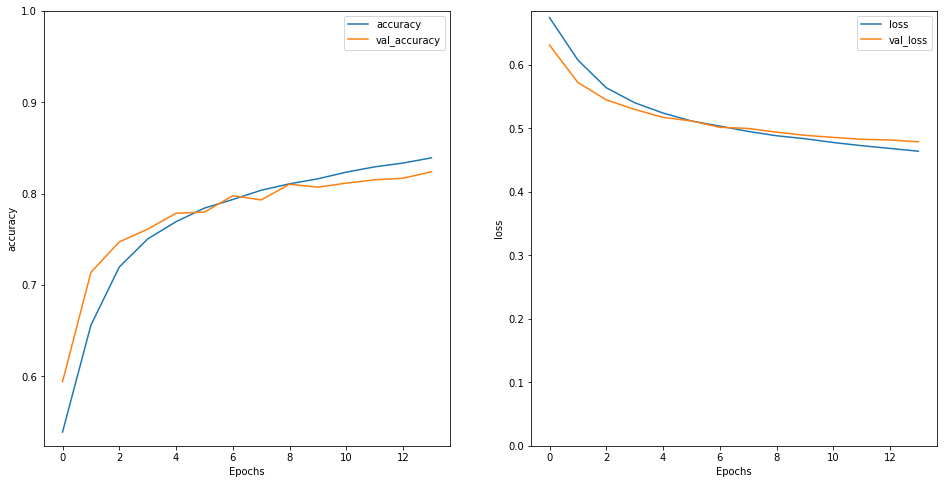

In [74]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_LSTM1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_LSTM1, 'loss')
plt.ylim(0, None)

### 모델3. MeCab과 LSTM 2레이어로 구성

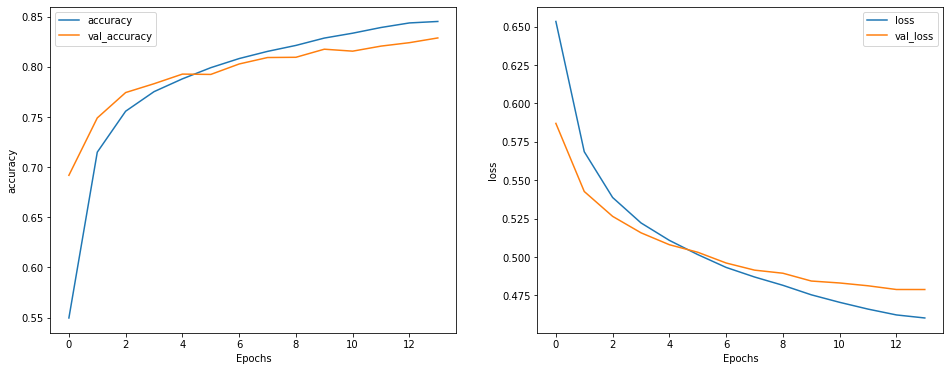

In [75]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_LSTM2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_LSTM2, 'loss')

### 모델4. SentencePiece와 LSTM 으로 구성

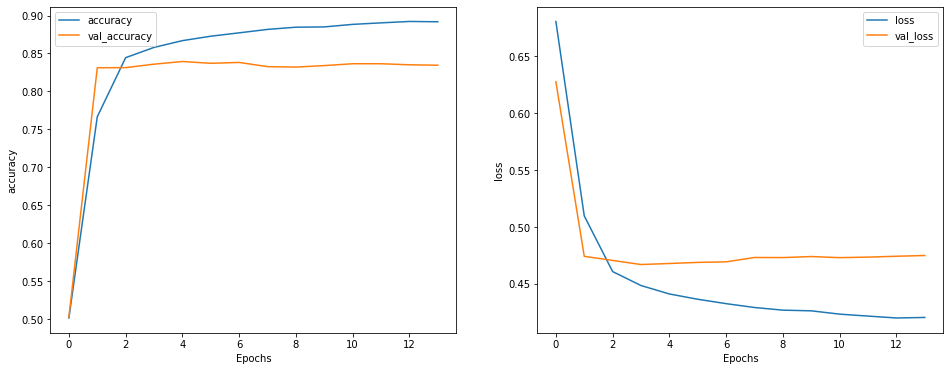

In [76]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_LSTM_SP, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_LSTM_SP, 'loss')

# 모델별 영화평 호감도 예측 점수

### 모델1. MeCab과 컨볼루션 레이어로 구성

In [77]:
sentences = (['ㅋㅋㅋ 난생처음 로그인하고 평점남기네요.. 개빡쳐서.. 알바들 속지마세요 이런 ㄱ ㅐ같은 시간낭비가. 아놔진짜평점 마이너스 별오만개',
             '최고최고! 바다까지! 4차원 고양이 로봇 도라에몽과 함께하는 진구와 친구들의 미지 탐험 이야기!우주꺼지 갔음 좋겠당~'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.12648603]
 [0.8506328 ]]


### 모델2. MeCab과 LSTM 으로 구성

In [78]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[-0.99890417]
 [ 0.5164766 ]]


### 모델3. MeCab과 LSTM 2레이어로 구성

In [79]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[-0.99967074]
 [ 0.9995213 ]]


### 모델4. SentencePiece와 LSTM 으로 구성

In [80]:
predict2(model_LSTM_SP, sentences)

[[-1.       ]
 [ 0.9999973]]


## 다른 영화평 예측점수

### 모델1. MeCab과 컨볼루션 레이어로 구성

In [81]:
sentences = (['다시 보고 싶은 영화. 스토리는 독특하고 연기는 자연스럽게 묻어난다. ',
             '정말 가슴아픈영화....질리지도 않는영화....몇번을봐도...음악도 너무 좋아요...OST도 구해 들었다는...'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.9615956]
 [0.9986076]]


### 모델2. MeCab과 LSTM 으로 구성

In [82]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[0.9996607]
 [1.       ]]


### 모델3. MeCab과 LSTM 2레이어로 구성

In [83]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[0.9999663 ]
 [0.99999505]]


### 모델4. SentencePiece와 LSTM 으로 구성

In [84]:
predict2(model_LSTM_SP, sentences)

[[1.]
 [1.]]


### 모델1. MeCab과 컨볼루션 레이어로 구성

In [85]:
sentences = (['끝까지 몰입해서 볼 수 있게 chapter로 나누어서 군더더기를 생략.좋은 상대와의 결혼도 권태는 피할 수 없고 나이들면 죽음보다 더 비참한 망각-치매-가 오게 되니 100년을 살게 되면 이를 어찌 극복할 수 있을까. ',
             '좋은 배우들을 이런 영상물로 연출한것은… 너무한거 아니오'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.65801525]
 [0.19614173]]


### 모델2. MeCab과 LSTM 으로 구성

In [86]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[ 0.9903069]
 [-0.9997293]]


### 모델3. MeCab과 LSTM 2레이어로 구성

In [87]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[ 0.9700645]
 [-0.9996795]]


### 모델4. SentencePiece와 LSTM 으로 구성

In [88]:
predict2(model_LSTM_SP, sentences)

[[ 0.9999989]
 [-0.9999752]]


### 모델1. MeCab과 컨볼루션 레이어로 구성

In [89]:
sentences = (['정치 선동 영화입니다. 대선을 얼마 안남기고 전형적인 민주당식 감정 몰이 영화네요.',
             '한효주 주연하지 말아요 제발.굳이 애써 평점을 남기게 만드는 영화.모든 면에서 다채롭게 유치합니다.'])
predict(model_Conv1D, sentences, word_to_index, index_to_word, maxlen)

[[0.5327185 ]
 [0.12648603]]


### 모델2. MeCab과 LSTM 으로 구성

In [90]:
predict(model_LSTM1, sentences, word_to_index, index_to_word, maxlen)

[[-0.8451643 ]
 [ 0.60452926]]


### 모델3. MeCab과 LSTM 2레이어로 구성

In [91]:
predict(model_LSTM2, sentences, word_to_index, index_to_word, maxlen)

[[-0.97808015]
 [-0.97327685]]


#### 보기엔 부정적인 평가인데 모델3은 긍정평가라 예측했다. 마지막 부분에 SentencePiece와 LSTM 2레이어로 구성한 모델로 예측한 결과가 있다.

### 모델4. SentencePiece와 LSTM 으로 구성

In [92]:
predict2(model_LSTM_SP, sentences)

[[-0.9999997]
 [-0.9990001]]


## 후기  
#### 네이버 영화평점을 SentencePiece을 이용해서 예측하는  과제다.  
#### 목적을 위해 모델4. SentencePiece와 LSTM을 구성했다.  
#### 모델의 예측값은 tanh 함수를 통과시켜 -1(낮은평가)~1(높은평가) 로 표현되게했다.  
#### SentencePiece 토큰화의 특성상 불용어라고 지워버리던 것들도 의미를 가질 수 있기 때문에 제거하지 않았다. 글자가 같다고 해서 불용어로 분류하여 제거하는 과정도 동음이의어가 사라지는 경우가 많아 세련되지 못하다.  
#### 기존에 했던 과제들과 비교해보면 모델4. SentencePiece와 LSTM  구성은 수렴이 아주 빠르고 평점예측에 단호했다. 1도 나오고 -1도 나온다.

### 혹시나 해서 돌려본거

In [93]:
model_LSTM2_SP = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 input_length=maxlen, 
                                 trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='tanh') #추가     
])

model_LSTM2_SP.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 21, 200)           1600000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 21, 128)          135680    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [94]:
print([layer.supports_masking for layer in model_LSTM2_SP.layers])

[False, True, True, True, True, True]


In [95]:
model_LSTM2_SP.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [96]:
history_LSTM2_SP = model_LSTM2_SP.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
131/131 [==============================] - 13s 65ms/step - loss: 0.6746 - accuracy: 0.5133 - val_loss: 0.5488 - val_accuracy: 0.7163
Epoch 2/30
131/131 [==============================] - 7s 54ms/step - loss: 0.4911 - accuracy: 0.8106 - val_loss: 0.4738 - val_accuracy: 0.8296
Epoch 3/30
131/131 [==============================] - 7s 53ms/step - loss: 0.4610 - accuracy: 0.8452 - val_loss: 0.4713 - val_accuracy: 0.8324
Epoch 4/30
131/131 [==============================] - 7s 54ms/step - loss: 0.4499 - accuracy: 0.8583 - val_loss: 0.4724 - val_accuracy: 0.8314
Epoch 5/30
131/131 [==============================] - 7s 53ms/step - loss: 0.4439 - accuracy: 0.8655 - val_loss: 0.4755 - val_accuracy: 0.8337
Epoch 6/30
131/131 [==============================] - 7s 53ms/step - loss: 0.4402 - accuracy: 0.8695 - val_loss: 0.4720 - val_accuracy: 0.8358
Epoch 7/30
131/131 [==============================] - 7s 53ms/step - loss: 0.4347 - accuracy: 0.8756 - val_loss: 0.4752 - val_accuracy: 0.831

In [97]:
test_loss, test_acc = model_LSTM2_SP.evaluate(x_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1537/1537 [==============================] - 18s 11ms/step - loss: 0.4823 - accuracy: 0.8295
Test Loss: 0.4822749197483063
Test Accuracy: 0.8294647932052612


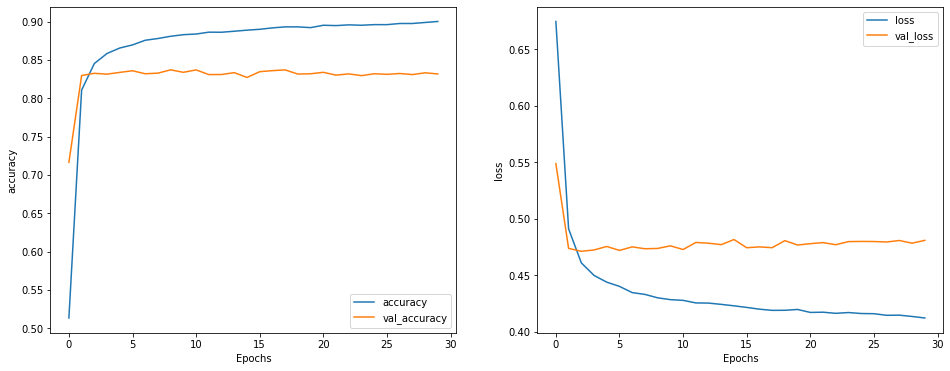

In [98]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_LSTM2_SP, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_LSTM2_SP, 'loss')

In [99]:
sentences = (['정치 선동 영화입니다. 대선을 얼마 안남기고 전형적인 민주당식 감정 몰이 영화네요.',
             '한효주 주연하지 말아요 제발.굳이 애써 평점을 남기게 만드는 영화.모든 면에서 다채롭게 유치합니다.'])
predict2(model_LSTM_SP, sentences)

[[-0.9999997]
 [-0.9990001]]


#### 위의 문장으로 평점을 예측했을 때 SentencePiece와 LSTM 2레이어로 구성한 모델로 예측한 결과는 MeCab과 LSTM 2레이어로 구성된 모델의 예측과 다르게 부정적 평가이다. 이는 주관적인 평과와 일치한다.   
